## 深層畳み込み敵対的生成ネットワーク(DCGAN)

- GAN とは？
  - 敵対的生成ネットワーク (GAN) は現在コンピュータサイエンス分野で最も興味深い構想です
  - 2 つのモデルが敵対的なプロセスにより同時にトレーニングされます
  - ジェネレータ(芸術家)が本物のような画像の制作を学習する一方で、ディスクリミネータ(芸術評論家)は本物の画像を偽物と見分けることを学習します
- トレーニングにより
  - ジェネレータでは、本物に見える画像の作成が徐々に上達する
  - ディスクリミネータでは、本物と偽物の区別が上達します
  - ディスクリミネータが本物と偽物の画像を区別できなくなった時点で平衡に達します

In [274]:
import tensorflow as tf
print(tf.__version__)

import glob
import imageio
# import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

2.17.0


In [233]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [234]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## ジェネレータ
- Conv2DTranspose (アップサンプリング) レイヤーを使用して、シード (ランダムノイズ) から画像を生成
- このシードを入力として取る Dense レイヤーから始め
- 待する画像サイズ (28x28x1) に到達するまで何度もアップサンプリングします
- tanh を使用する出力レイヤーを除き、各レイヤーに LeakyReLU アクティベーションが使用

In [235]:
def make_generator_model():
    model = tf.keras.Sequential(name='generator')
    model.add(tf.keras.Input(shape=(100,), name='input'))

    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 1)

    return model

model = make_generator_model()

# model.summary()

ジェネレータテスト

(1, 100)


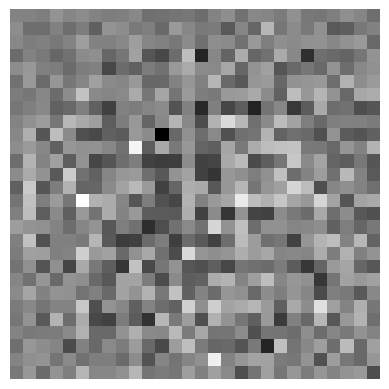

In [236]:
generator = make_generator_model()
noise = tf.random.normal(shape=[1, 100]) # N(0, 1)を100出力
print(noise.shape)
# noise = tf.random.Generator.from_seed(1).normal(shape=[1, 100])
generated_images = generator(noise, training=False)

plt.imshow(generated_images[0, :, :, 0], cmap='gray')
plt.axis(False)
plt.show()

ディスクリミネータ
- CNNベースの画像分類子

In [237]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='discriminator')
    model.add(tf.keras.Input(shape=(28, 28, 1), name='input'))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


model = make_discriminator_model()

# model.summary()

ディスクリミネータ出力

In [238]:
discriminator = make_discriminator_model()
dicision = discriminator(generated_images)
dicision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00034261]], dtype=float32)>

ディスクリミネータの損失

In [239]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

ジェネレータの損失

In [240]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

オプティマイザー

In [241]:
generator_oprimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_oprimizer = tf.keras.optimizers.Adam(1e-4)

チェックポイントの保存

In [242]:
checkpoint_dir = "../notebook/training_checkpoint"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_oprimizer=generator_oprimizer,
    discriminator_oprimizer=discriminator_oprimizer,
    generator=generator,
    discriminator=discriminator,
)

トレーニンググループの定義
- ランダムシードを入力として受け取っているジェネレータから始まります
- そのシードを使って画像が生成されると、
  - ディスクリミネータを使って本物の画像（トレーニングセットから取り出された画像）と偽物の画像（ジェネレータが生成した画像）が分類されます
  - これらの各モデルに対して損失が計算されると、勾配を使用してジェネレータとディスクリミネータが更新されます。

In [243]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [244]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_oprimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_oprimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

画像を生成して保存

In [245]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis(False)

    plt.savefig(f'../images/imega_at_epoch{epoch:04d}.png')

トレーニング

In [246]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch+1} is {time.time()-start}')

    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [290]:
def yes_no_input():
    while True:
        choice = input("Please respond with 'yes' or 'no' [y/N]: ").lower()
        if choice in ['y', 'ye', 'yes']:
            return True
        elif choice in ['n', 'no']:
            return False

In [291]:
if yes_no_input():
    print('OK!')
    train(train_dataset, EPOCHS)
else:
    print('STOP!')

STOP!


In [287]:
files = glob.glob("../images/imega*")
# print(len(files))

images = []
for file in files:
    im = PIL.Image.open(file)
    images.append(im)

images[0].save(
    "../images/test.gif",
    save_all=True,
    append_images=images[1:],
    optimize=False,
    duration=250,
    loop=0,
)

In [1]:
import tensorflow_docs.vis.embed as embed
# embed.embed_file("../images/test.gif")